In [1]:
import pandas as pd
import re
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import wordnet
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import datetime

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vileg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# read the data from .csv file and store it as a dataframe
tweets_data = pd.read_csv('csv/vaccination_all_tweets.csv', engine='python')

In [3]:
tweets_data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [4]:
# examine the contents of all the columns
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                228207 non-null  int64 
 1   user_name         228205 non-null  object
 2   user_location     161296 non-null  object
 3   user_description  211189 non-null  object
 4   user_created      228207 non-null  object
 5   user_followers    228207 non-null  int64 
 6   user_friends      228207 non-null  int64 
 7   user_favourites   228207 non-null  int64 
 8   user_verified     228207 non-null  bool  
 9   date              228207 non-null  object
 10  text              228207 non-null  object
 11  hashtags          178504 non-null  object
 12  source            228088 non-null  object
 13  retweets          228207 non-null  int64 
 14  favorites         228207 non-null  int64 
 15  is_retweet        228207 non-null  bool  
dtypes: bool(2), int64(6), object(8)
memory

In [5]:
# convert date column to datetime stamp
tweets_data['date'] = pd.to_datetime(tweets_data['date'])

In [6]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228207 entries, 0 to 228206
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                228207 non-null  int64         
 1   user_name         228205 non-null  object        
 2   user_location     161296 non-null  object        
 3   user_description  211189 non-null  object        
 4   user_created      228207 non-null  object        
 5   user_followers    228207 non-null  int64         
 6   user_friends      228207 non-null  int64         
 7   user_favourites   228207 non-null  int64         
 8   user_verified     228207 non-null  bool          
 9   date              228207 non-null  datetime64[ns]
 10  text              228207 non-null  object        
 11  hashtags          178504 non-null  object        
 12  source            228088 non-null  object        
 13  retweets          228207 non-null  int64         
 14  favo

In [7]:
# check for duplicate values
tweets_data[tweets_data.duplicated()]

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet


In [8]:
# returns total rows and columns, respectively as a tuple
tweets_data.shape

(228207, 16)

<h2>Clean tweets</h2>

In [9]:
def clean_tweets(tweets):
    # Add whitespace to the end of every tweet
    tweets['clean_tweet'] = tweets['text'].map(lambda x: x + " ") 
    # Remove http links
    tweets['clean_tweet'] = tweets['clean_tweet'].map(lambda x: re.sub(r'http.*', '', x))
    # Remove special characters and numbers
    tweets['clean_tweet'] = tweets['clean_tweet'].map(lambda x: re.sub(r"[^a-zA-Z#]", ' ', x))
    # Lowercase all tweets
    tweets['clean_tweet'] = tweets['clean_tweet'].map(lambda x: x.lower())
    # Tokenize words, eliminate stop words and store them back
    stopword_list = stopwords.words('english')
    for i in range(0, len(tweets['clean_tweet'])):
        tokens = word_tokenize(tweets['clean_tweet'].iloc[i])
        clean_tokens = [t for t in tokens if t not in stopword_list]
        tweets['clean_tweet'].iloc[i] = clean_tokens

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vileg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
clean_tweets(tweets_data)

C:\Users\vileg\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [12]:
tweets_data['clean_tweet'].iloc[0]

['folks',
 'said',
 'daikon',
 'paste',
 'could',
 'treat',
 'cytokine',
 'storm',
 '#',
 'pfizerbiontech']

<h2>Lemmatize tweets</h2>

In [13]:
def lemmatize_tweet(tweets):
    
    for i in range(len(tweets)):
        # Pos-tag each word in tweet
        for word in [tweets[i]]:
            pos_tag_list = nltk.pos_tag(word)
        # Convert pos-tag to be wordnet compliant
        wordnet_tags = []
        for j in pos_tag_list:
            # Adjective
            if j[1].startswith('J'):
                wordnet_tags.append(wordnet.ADJ)
            # Noun
            elif j[1].startswith('N'):
                wordnet_tags.append(wordnet.NOUN)
            # Adverb
            elif j[1].startswith('R'):
                wordnet_tags.append(wordnet.ADV)
            # Verb
            elif j[1].startswith('V'):
                wordnet_tags.append(wordnet.VERB)
            # Default to noun
            else:
                wordnet_tags.append(wordnet.NOUN)
        # Lemmatize each word in tweet
        lem_words = []
        for k in range(len(tweets[i])):
            lem_words.append(lemmatizer.lemmatize(tweets[i][k], pos=wordnet_tags[k]))
        lem_tweet = ' '.join(lem_words)
        tweets[i] = lem_tweet

In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\vileg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vileg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
lemmatize_tweet(tweets_data.clean_tweet)

C:\Users\vileg\AppData\Local\Temp/ipykernel_22988/2297349296.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets[i] = lem_tweet


In [17]:
tweets_data['clean_tweet'].iloc[0]

'folk say daikon paste could treat cytokine storm # pfizerbiontech'

In [18]:
tweets_data['clean_tweet'] = tweets_data['clean_tweet'].map(lambda x: x.replace('#', ''))

In [19]:
tweets_data['clean_tweet'][0]

'folk say daikon paste could treat cytokine storm  pfizerbiontech'

In [20]:
#extracting tweets that contain only the keyword 'pfizer'
pfizer_tweets = tweets_data[tweets_data['clean_tweet'].str.contains('pfizer')]

In [21]:
len(pfizer_tweets)

22021

<h2>Exploratory Data Analysis</h2>

<h3>1. What are the most common words?</h3>

In [22]:
# combine all the tweets to form a single tweet
pfizer_tweets_combined = ' '.join([tweet for tweet in pfizer_tweets['clean_tweet']])

In [23]:
pfizer_tweets_combined

'folk say daikon paste could treat cytokine storm  pfizerbiontech  coronavirus  sputnikv  astrazeneca  pfizerbiontech  moderna  covid russian vaccine create last year explain need vaccine borisjohnson matthancock  whereareallthesickpeople  pfizerbiontech covid vaccine get  covidvaccine  covid  pfizerbiontech  moderna death close mark million people wait  pfizerbiontech  vaccine first u cnnbrk  covid  covidvaccine  vaccine  corona  pfizerbiontech  bbcnews  nytimes  bbcnews best wish u woman healthcare provider ask safety  pfizerbiontech updated  yellowfever amp  covid  immunitypassports part two  sarscov  pfizerbiontech  britain  december coronavirus iran report new case death last hour  iran  coronavirus  pfizerbiontech pfizer rake billion expensive  covidvaccine albertbourla refuse cut price lowe anyone wonder day  pfizerbiontech approval uk people get vaccinated tol u food drug administration fda grant emergency use authorization pfizer biontech mrna do  thankyounhs nhsuk mhragovuk  

In [24]:
# split the single tweet into words and store it in a list
pfizer_tweets_words_list = pfizer_tweets_combined.split()

In [25]:
pfizer_tweets_words_list

['folk',
 'say',
 'daikon',
 'paste',
 'could',
 'treat',
 'cytokine',
 'storm',
 'pfizerbiontech',
 'coronavirus',
 'sputnikv',
 'astrazeneca',
 'pfizerbiontech',
 'moderna',
 'covid',
 'russian',
 'vaccine',
 'create',
 'last',
 'year',
 'explain',
 'need',
 'vaccine',
 'borisjohnson',
 'matthancock',
 'whereareallthesickpeople',
 'pfizerbiontech',
 'covid',
 'vaccine',
 'get',
 'covidvaccine',
 'covid',
 'pfizerbiontech',
 'moderna',
 'death',
 'close',
 'mark',
 'million',
 'people',
 'wait',
 'pfizerbiontech',
 'vaccine',
 'first',
 'u',
 'cnnbrk',
 'covid',
 'covidvaccine',
 'vaccine',
 'corona',
 'pfizerbiontech',
 'bbcnews',
 'nytimes',
 'bbcnews',
 'best',
 'wish',
 'u',
 'woman',
 'healthcare',
 'provider',
 'ask',
 'safety',
 'pfizerbiontech',
 'updated',
 'yellowfever',
 'amp',
 'covid',
 'immunitypassports',
 'part',
 'two',
 'sarscov',
 'pfizerbiontech',
 'britain',
 'december',
 'coronavirus',
 'iran',
 'report',
 'new',
 'case',
 'death',
 'last',
 'hour',
 'iran',
 'co

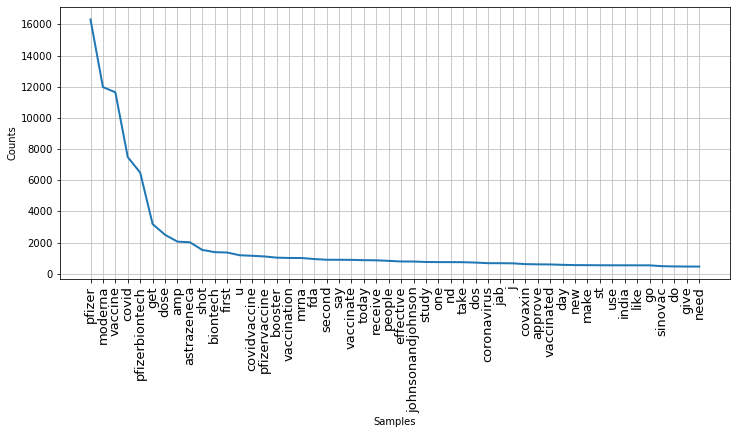

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [26]:
# plot the frequency distribution for first 30 words
plt.figure(figsize = (12, 5))
plt.xticks(fontsize = 13, rotation = 90)
freq_dist = nltk.FreqDist(pfizer_tweets_words_list)
freq_dist.plot(50, cumulative = False)

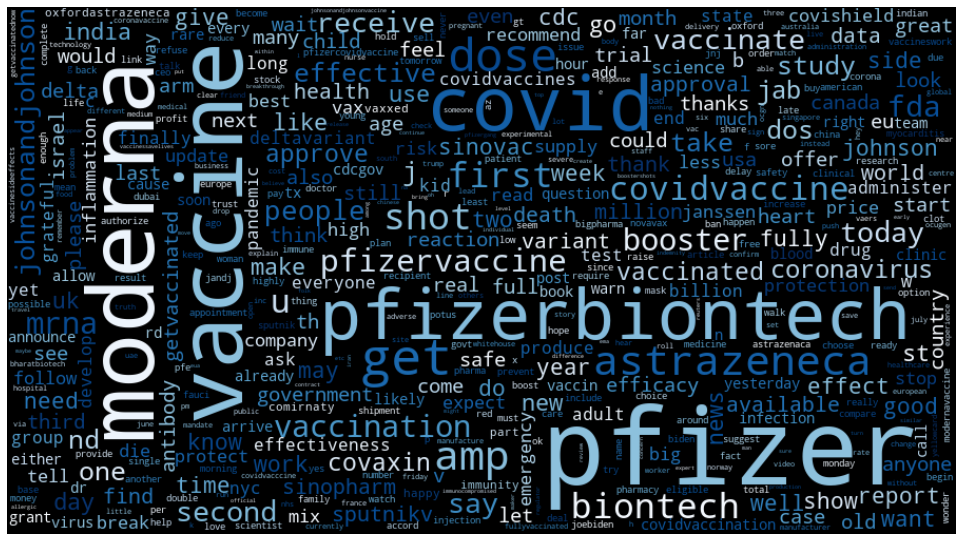

In [27]:
# wordcloud with word frequencies 
wordcloud = WordCloud(width = 900, height = 500, max_words = 500, max_font_size = 100, relative_scaling = 0.5, colormap = 'Blues', normalize_plurals = True).generate_from_frequencies(freq_dist)
plt.figure(figsize = (17, 14))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

<h3>2. What is the frequency of each word?</h3>

In [28]:
freq_dist

FreqDist({'pfizer': 16311, 'moderna': 11974, 'vaccine': 11639, 'covid': 7479, 'pfizerbiontech': 6487, 'get': 3184, 'dose': 2497, 'amp': 2059, 'astrazeneca': 2018, 'shot': 1526, ...})

In [29]:
word_freq = nltk.FreqDist(pfizer_tweets_words_list)
word_freq_df = pd.DataFrame({'Word': list(word_freq.keys()), 'Frequency': list(word_freq.values())}).sort_values(by = ['Frequency'], ascending = False)
word_freq_df.head(30)

,Word,Frequency
59,pfizer,16311
12,moderna,11974
15,vaccine,11639
13,covid,7479
8,pfizerbiontech,6487
24,get,3184
172,dose,2497
47,amp,2059
11,astrazeneca,2018
381,shot,1526


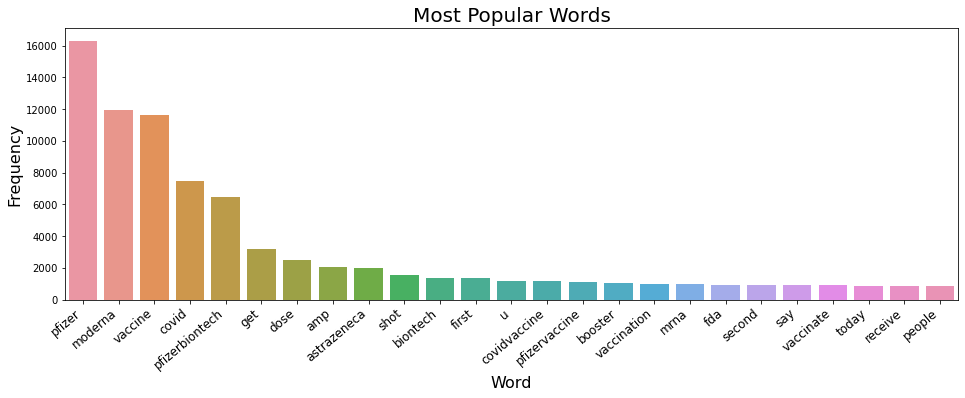

In [30]:
# Plot histogram of most frequent words

word_freq_df = word_freq_df.nlargest(columns="Frequency", n = 25) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=word_freq_df, x= "Word", y = "Frequency")
ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Word', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Most Popular Words", fontsize=20)
plt.show()

<h3>3. What time sees the most number of tweets?</h3>

In [31]:
# Create a dataframe grouping the number of tweets by hour of the day

tweets_hour_df = pd.DataFrame(pfizer_tweets.groupby(pfizer_tweets['date'].dt.hour)['clean_tweet'].count()).reset_index()
tweets_hour_df = tweets_hour_df.rename(columns={'date': 'Hour', 'clean_tweet': 'Frequency'})
tweets_hour_df.Hour = tweets_hour_df.Hour.replace([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0], ['12:00 AM', '1:00 AM', '2:00 AM', '3:00 AM', '4:00 AM', '5:00 AM', '6:00 AM', '7:00 AM', '8:00 AM', '9:00 AM', '10:00 AM', '11:00 AM', '12:00 AM', '1:00 PM', '2:00 PM', '3:00 PM', '4:00 PM', '5:00 PM', '6:00 PM', '7:00 PM', '8:00 PM', '9:00 PM', '10:00 PM', '11:00 PM'])
tweets_hour_df

,Hour,Frequency
0,12:00 AM,660
1,1:00 AM,695
2,2:00 AM,690
3,3:00 AM,705
4,4:00 AM,717
5,5:00 AM,662
6,6:00 AM,662
7,7:00 AM,738
8,8:00 AM,690
9,9:00 AM,780


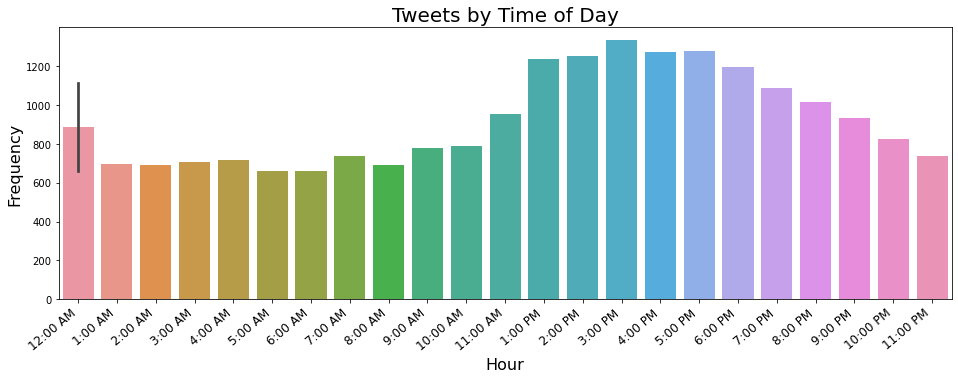

In [32]:
# Plot histogram of Tweet Counts by Hour

plt.figure(figsize=(16,5))
ax = sns.barplot(data=tweets_hour_df, x= "Hour", y = "Frequency")
ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Hour', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Tweets by Time of Day", fontsize=20)
plt.show()

<h3>4. Which days sees the most number of tweets?</h3>

In [33]:
# Create a dataframe grouping the number of tweets by hour of the day
tweets_day_df = pd.DataFrame(pfizer_tweets.resample('D', on='date')['clean_tweet'].count()).reset_index().sort_values(by='clean_tweet', ascending=False)
tweets_day_df = tweets_day_df.rename(columns={'date': 'Day', 'clean_tweet': 'Frequency'})
tweets_day_df.head()

,Day,Frequency
163,2021-05-24,210
254,2021-08-23,199
342,2021-11-19,175
122,2021-04-13,173
249,2021-08-18,170


In [34]:
top_tweeted_days = tweets_day_df.sort_values(by = ['Frequency'], ascending=False)[:30]
top_tweeted_days

,Day,Frequency
163,2021-05-24,210
254,2021-08-23,199
342,2021-11-19,175
122,2021-04-13,173
249,2021-08-18,170
255,2021-08-24,163
242,2021-08-11,156
199,2021-06-29,155
198,2021-06-28,152
125,2021-04-16,151


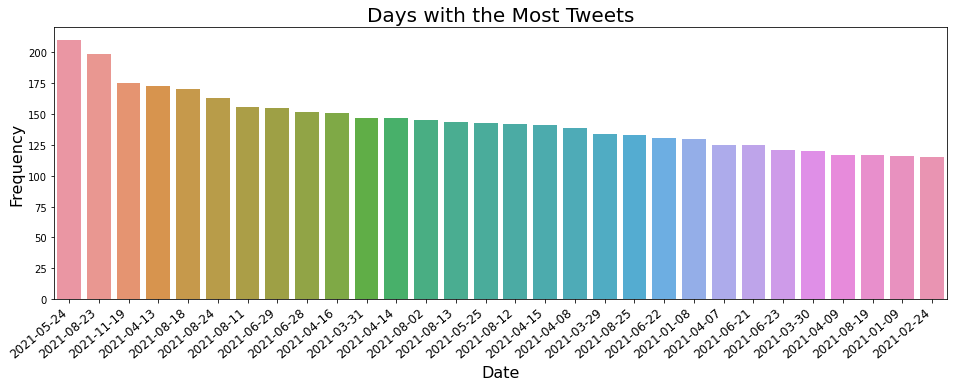

In [35]:
# Plot histogram of Tweet Counts by Day

plt.figure(figsize=(16,5))
ax = sns.barplot(data=top_tweeted_days, x= top_tweeted_days.Day.dt.date, y = "Frequency")
ax.set_ylabel('Frequency', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=12)
ax.set_title("Days with the Most Tweets", fontsize=20)
plt.show()

In [36]:
# Save the processed tweets data to file
pfizer_tweets.to_csv(r'csv/pfizer_processed_tweets.csv', encoding = 'utf-8')